In [1]:
from __future__ import absolute_import, division, print_function

from datetime import datetime
import os
from shutil import copyfile

import tensorflow as tf
print('Tensorflow Version: ', tf.__version__)
from tensorflow.keras import Model, layers
import numpy as np

from google.colab import drive

drive.mount('/content/gdrive')
drive_dest_folder = '/content/gdrive/My Drive/Colab Notebooks/data'

# MNIST Dataset parameters.
num_features = 784 # data features (img shape: 28*28).

# Network parameters.
noise_dim = 100 # Noise data points.

Tensorflow Version:  2.0.0-alpha0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Create TF Model.
class Generator(Model):
    # Set layers.
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = layers.Dense(7 * 7 * 128)
        self.bn1 = layers.BatchNormalization()
        self.conv2tr1 = layers.Conv2DTranspose(64, 5, strides=2, padding='SAME')
        self.bn2 = layers.BatchNormalization()
        self.conv2tr2 = layers.Conv2DTranspose(1, 5, strides=2, padding='SAME')

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.bn1(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        # Reshape to a 4-D array of images: (batch, height, width, channels)
        # New shape: (batch, 7, 7, 128)
        x = tf.reshape(x, shape=[-1, 7, 7, 128])
        # Deconvolution, image shape: (batch, 14, 14, 64)
        x = self.conv2tr1(x)
        x = self.bn2(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        # Deconvolution, image shape: (batch, 28, 28, 1)
        x = self.conv2tr2(x)
        x = tf.nn.tanh(x)
        return x

# Generator Network
# Input: Noise, Output: Image
# Note that batch normalization has different behavior at training and inference time,
# we then use a placeholder to indicates the layer if we are training or not.
class Discriminator(Model):
    # Set layers.
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = layers.Conv2D(64, 5, strides=2, padding='SAME')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(128, 5, strides=2, padding='SAME')
        self.bn2 = layers.BatchNormalization()
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(1024)
        self.bn3 = layers.BatchNormalization()
        self.fc2 = layers.Dense(2)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = self.conv1(x)
        x = self.bn1(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn3(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        return self.fc2(x)


In [0]:
def save_model_to_google_drive(model):
  dated_file_name = str(datetime.now().strftime('%Y_%m_%d_%H_%M_%S'))
  file_name = '{0}_{1}.ckpt'.format(
      model.__class__.__name__, dated_file_name)
  print('Saving -> {}'.format(file_name))
  model.save_weights(
      filepath=os.path.join(drive_dest_folder, file_name))


def load_latest_model(model):
  model_files = [
      f
      for f in os.listdir(drive_dest_folder)
      if model.__class__.__name__ in f
  ]
  model_files.sort()
  latest_file_name = '{}.ckpt'.format(model_files[-1].split('.')[0])
  latest_filepath = os.path.join(drive_dest_folder, latest_file_name)
  print('Loading -> {}'.format(latest_filepath))
  model.load_weights(filepath=latest_filepath)
  return model

In [0]:
# Build neural network model from SCRATCH
generator = Generator()
discriminator = Discriminator()

In [8]:
# Build neural network model from PREVIOUS SAVED DATA
generator = load_latest_model(Generator())
discriminator = load_latest_model(Discriminator())

Loading -> /content/gdrive/My Drive/Colab Notebooks/data/Generator_2019_05_22_15_18_18.ckpt
Loading -> /content/gdrive/My Drive/Colab Notebooks/data/Discriminator_2019_05_22_15_18_18.ckpt


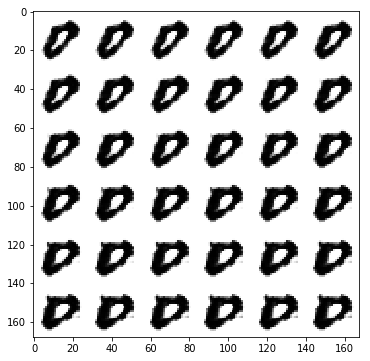

In [62]:
# Visualize predictions.
import matplotlib.pyplot as plt


def generate_sliding_noise(indexes_to_slide=[0]):
  noise_line = np.random.normal(-1., 1., size=noise_dim).astype(np.float32)
  noise = np.zeros([36, 100]).astype(np.float32)
  for i in range(z.shape[0]):
    noise[i] = noise_line
    for n in indexes_to_slide:
      noise[i][n] = ((i / (noise.shape[0] - 1)) * 2) - 1
  return noise


def draw_noise(z):
  # Generate image from noise.
  g = generator(z).numpy()
  # Rescale to original [0, 1]
  g = (g + 1.) / 2
  # Reverse colours for better display
  g = -1 * (g - 1)
  canvas = np.empty((28 * n, 28 * n))
  for i in range(n):
      for j in range(n):
          # Draw the generated digits
          canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[(i * n) + j].reshape([28, 28])
  plt.figure(figsize=(n, n))
  plt.imshow(canvas, origin="upper", cmap="gray")
  plt.show()


# Generate images from noise, using the generator network.
n = 6
# Noise input.
# z = np.random.normal(-1., 1., size=[n * n, noise_dim]).astype(np.float32)
draw_noise(generate_sliding_noise([10,20,30,40,50,60, 70, 80,90]))

In [0]:
# Training parameters.
lr_generator = 0.0002
lr_discriminator = 0.0002
training_steps = 5000
batch_size = 128
display_step = 500

In [0]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)

In [0]:
# Losses.
def generator_loss(disc_output):
    gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=disc_output, labels=tf.ones([batch_size], dtype=tf.int32)))
    return gen_loss

def discriminator_loss(disc_fake, disc_real):
    disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=disc_real, labels=tf.ones([batch_size], dtype=tf.int32)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=disc_fake, labels=tf.zeros([batch_size], dtype=tf.int32)))
    return disc_loss_real + disc_loss_fake

# Optimizers.
optimizer_gen = tf.optimizers.Adam(learning_rate=lr_generator)#, beta_1=0.5, beta_2=0.999)
optimizer_disc = tf.optimizers.Adam(learning_rate=lr_discriminator)#, beta_1=0.5, beta_2=0.999)

In [0]:
# Optimization process. Inputs: real image and noise.
def run_optimization(real_images):
    
    # Rescale to [-1, 1], the input range of the discriminator
    real_images = real_images * 2. - 1.

    # Generate noise.
    noise = np.random.normal(-1., 1., size=[batch_size, noise_dim]).astype(np.float32)
    
    with tf.GradientTape() as g:
            
        fake_images = generator(noise, is_training=True)
        disc_fake = discriminator(fake_images, is_training=True)
        disc_real = discriminator(real_images, is_training=True)

        disc_loss = discriminator_loss(disc_fake, disc_real)
            
    # Training Variables for each optimizer
    gradients_disc = g.gradient(disc_loss,  discriminator.trainable_variables)
    optimizer_disc.apply_gradients(zip(gradients_disc,  discriminator.trainable_variables))
    
    # Generate noise.
    noise = np.random.normal(-1., 1., size=[batch_size, noise_dim]).astype(np.float32)
    
    with tf.GradientTape() as g:
            
        fake_images = generator(noise, is_training=True)
        disc_fake = discriminator(fake_images, is_training=True)

        gen_loss = generator_loss(disc_fake)
            
    gradients_gen = g.gradient(gen_loss, generator.trainable_variables)
    optimizer_gen.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    
    return gen_loss, disc_loss

In [11]:
# Run training for the given number of steps.
for step, (batch_x, _) in enumerate(train_data.take(training_steps + 1)):
    
    if step == 0:
        # Generate noise.
        noise = np.random.normal(-1., 1., size=[batch_size, noise_dim]).astype(np.float32)
        gen_loss = generator_loss(discriminator(generator(noise)))
        disc_loss = discriminator_loss(discriminator(batch_x), discriminator(generator(noise)))
        print("initial: gen_loss: %f, disc_loss: %f" % (gen_loss, disc_loss))
        continue
    
    # Run the optimization.
    gen_loss, disc_loss = run_optimization(batch_x)
    
    if step % display_step == 0:
        print("step: %i, gen_loss: %f, disc_loss: %f" % (step, gen_loss, disc_loss))

initial: gen_loss: 2.668866, disc_loss: 2.694618
step: 500, gen_loss: 3.366920, disc_loss: 0.191741
step: 1000, gen_loss: 3.784293, disc_loss: 0.155192
step: 1500, gen_loss: 4.609366, disc_loss: 0.212447
step: 2000, gen_loss: 5.298974, disc_loss: 0.092677
step: 2500, gen_loss: 3.881725, disc_loss: 0.107746
step: 3000, gen_loss: 3.252800, disc_loss: 0.204092
step: 3500, gen_loss: 4.736138, disc_loss: 0.110404
step: 4000, gen_loss: 4.638585, disc_loss: 0.117195
step: 4500, gen_loss: 4.610701, disc_loss: 0.115803
step: 5000, gen_loss: 5.109273, disc_loss: 0.161861


In [12]:
save_model_to_google_drive(generator)
save_model_to_google_drive(discriminator)

Saving -> Generator_2019_05_22_15_30_20.ckpt
Saving -> Discriminator_2019_05_22_15_30_20.ckpt


In [50]:
index_to_slide = 0
z_start = np.random.normal(-1., 1., size=noise_dim).astype(np.float32)
z = np.zeros([36, 100]).astype(np.float32)
for i in range(z.shape[0]):
  z[i] = z_start
  z[i][index_to_slide] = ((i / (z.shape[0] - 1)) * 2) - 1

-1.0
-0.94285715
-0.8857143
-0.82857144
-0.7714286
-0.71428573
-0.6571429
-0.6
-0.54285717
-0.4857143
-0.42857143
-0.37142858
-0.31428573
-0.25714287
-0.2
-0.14285715
-0.08571429
-0.028571429
0.028571429
0.08571429
0.14285715
0.2
0.25714287
0.31428573
0.37142858
0.42857143
0.4857143
0.54285717
0.6
0.6571429
0.71428573
0.7714286
0.82857144
0.8857143
0.94285715
1.0
